In [40]:
import warnings
warnings.filterwarnings("ignore")

### basic datatype libraries
import numpy.ma as ma
import pandas as pd
import numpy as np
from scipy import interpolate
import itertools
import random

### geo libraries
import geopandas as gpd

### Plotting libraries 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

### machine learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

### widgets and process bars
from tqdm.notebook import tqdm

### date and time libraries
from datetime import timedelta, date, datetime

# import UNet_DP as unet_dp
from IPython.display import clear_output

# PCA implementation

In [5]:
def remove_land(input_data): 
    # Reshape data by flattening the spatial dimensions
    data_reshaped = input_data.reshape(input_data.shape[0], 
                                       input_data.shape[1], 
                                       input_data.shape[2] * input_data.shape[3])

    nan_mask = np.isnan(data_reshaped).all(axis=(0, 1))
    non_nan_indices = np.where(~nan_mask)[0]
    data_cleaned = data_reshaped[:, :, ~nan_mask]

    return data_cleaned, non_nan_indices

def restore_land(data_cleaned, non_nan_indices):
    n_var = 7
    # # Create an empty array with the original spatial dimensions filled with NaN
    restored_data = np.full((data_cleaned.shape[0], n_var, 520, 360), np.nan)

    # Map the cleaned data back to its original spatial locations
    for i, idx in enumerate(non_nan_indices):
        lat_idx, lon_idx = np.unravel_index(idx, (520, 360))
        restored_data[:, :, lat_idx, lon_idx] = data_cleaned[:, :, i]

    return restored_data

In [14]:
### selected parameters
atlantic_data = ImportData.import_npy_data('/work3/anscha/Marine_heat_waves/DataProcessingPipelines/Polygons/Atlantic/atlantic_data.npy')

input_data = atlantic_data.swapaxes(0,1)
## test only for temperature
input_data = input_data[:, 4].reshape(228, 1, 520, 360)

########################################################################
##### Split data into train, validation and test#######################
########################################################################
train_ratio = 0.8
test_ratio = 0.1

# Split the data into training (80%) and temporary (10%) sets.
X_train, X_test = train_test_split(input_data, test_size=test_ratio, shuffle=True, random_state=40)

### remove land from data
X_train, non_nan_indices_train = remove_land(X_train)
X_test, non_nan_indices_test = remove_land(X_test)

########################################################################
##### Scale train and test #######################
########################################################################
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### there can be remaining missing values because different variables have a 
### slight difference in the data availability

### mask nan values
mask_value = 0 # Choose an appropriate mask value
nan_mask_train = np.isnan(X_train_scaled)
nan_mask_test = np.isnan(X_test_scaled)

X_train_scaled[nan_mask_train] = mask_value
X_test_scaled[nan_mask_test] = mask_value

# Print the shapes
print(f"Scaled Train set shape: {X_train_scaled.shape}")
print(f"Scaled Test set shape: {X_test_scaled.shape}")


Scaled Train set shape: (205, 130176)
Scaled Test set shape: (23, 130176)


In [15]:
class DenseTied(nn.Module):
    def __init__(self, tied_to, use_bias=True):
        super(DenseTied, self).__init__()
        self.tied_to = tied_to
        self.use_bias = use_bias
        if use_bias:
            self.bias = nn.Parameter(torch.Tensor(tied_to.in_features))
            self.reset_parameters()

    def reset_parameters(self):
        if self.use_bias:
            nn.init.zeros_(self.bias)

    def forward(self, x):
        if self.use_bias:
            return F.linear(x, self.tied_to.weight.t(), self.bias)
        else:
            return F.linear(x, self.tied_to.weight.t())
        
class LinearAutoencoder(nn.Module):
    
    def __init__(self, input_size, features = [512, 256, 128, 64], dropout_rate=0.0):
        super(LinearAutoencoder, self).__init__()

        self.features = features
        self.dropout_rate = dropout_rate

        # Encoder
        self.encoder_layers = nn.ModuleList()
        in_features = input_size
        for out_features in features[:-1]:
            self.encoder_layers.append(nn.Linear(in_features, out_features))
            in_features = out_features

        ## bottleneck
        self.bottleneck = nn.Linear(features[-2], features[-1]) 

        # Decoder (tied weights)
        # self.decoder_layers = nn.ModuleList()
        # self.decoder_layers.append(DenseTied(tied_to=self.bottleneck, use_bias=False))
        # for i in range(len(self.encoder_layers)):
        #     # Tying with the corresponding encoder layer
        #     tied_layer = self.encoder_layers[-(i+1)]
        #     self.decoder_layers.append(DenseTied(tied_to=tied_layer, use_bias=False)) ## bias can be changed to true
        
        # Decoder
        self.decoder_layers = nn.ModuleList()
        reversed_features = list(reversed(features))
        for i in range(len(reversed_features) - 1):
            self.decoder_layers.append(nn.Linear(reversed_features[i], reversed_features[i+1]))
        
        self.decoder_layers.append(nn.Linear(reversed_features[-1], input_size))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
    
        # Encoder forward pass
        for layer in self.encoder_layers:
            x = F.relu(layer(x))
            x = F.dropout(x, self.dropout_rate)

        ## add bottleneck
        x = F.relu(self.bottleneck(x))

        # Decoder forward pass
        for layer in self.decoder_layers[:-1]:
            x = F.relu(layer(x))

        # No ReLU for the final layer
        x = self.decoder_layers[-1](x)

        return x

    def encode(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.encoder_layers:
            x = F.relu(layer(x))

        ## add bottleneck
        x = self.bottleneck(x)
        return x
    
    ################ apply orthogonality ############################
    def enforce_orthogonality(self, weightage=1.0):
        for layer in self.encoder_layers:
            self._apply_orthogonality(layer, weightage)
        for layer in self.decoder_layers:
            if isinstance(layer, DenseTied):  # Apply only if DenseTied layer
                self._apply_orthogonality(layer.tied_to, weightage)

    def _apply_orthogonality(self, layer, weightage):
        if layer.weight.shape[0] > 1:  # Orthogonality for 2D weights
            w = layer.weight.data
            m = torch.mm(w.t(), w) - torch.eye(w.shape[1], device=w.device)
            w.data -= weightage * torch.mm(w, m)
        else:  # Handling for 1D weights (if any)
            w = layer.weight.data
            m = torch.sum(w ** 2) - 1.0
            w.data -= weightage * m * w

    ################ apply uncorrelation ############################
    def compute_uncorrelated_penalty(self, encoded, weightage=1.0):
        if self.features[-1] <= 1:
            return 0.0
        else:
            x_centered = encoded - encoded.mean(dim=0)
            covariance = torch.mm(x_centered.t(), x_centered) / x_centered.shape[0]
            covariance -= torch.eye(self.features[-1], device=covariance.device)
            penalty = weightage * torch.sum(covariance ** 2)
            return penalty
    
    ################ apply UnitNorm ############################
    def enforce_unit_norm(self):
        for layer in self.encoder_layers:
            self._apply_unit_norm(layer)
        for layer in self.decoder_layers:
            self._apply_unit_norm(layer)

    def _apply_unit_norm(self, layer):
        with torch.no_grad():
            # Check if the layer is a DenseTied layer
            if isinstance(layer, DenseTied):
                weight = layer.tied_to.weight
            else:
                weight = layer.weight

            weight_norm = torch.norm(weight.data, p=2, dim=1, keepdim=True)
            weight.data.div_(weight_norm)

In [16]:
def train(model, criterion, optimizer, scheduler, num_epochs, BATCH_SIZE, X_train):
    
    minimum_loss = 1000 ## for mse loss

    train_loss_epochs = []

    ### creating tensor dataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float())

    for epoch in range(num_epochs):
        # Training Loop
        running_train_loss = 0.0 
        predicted_outputs = []

        torch.manual_seed(42)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        model.train()
        for inputs in train_loader:
            # Training code here
            inputs = inputs[0].to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            # Forward pass to get output
            pred_output_ = model(inputs)
            predicted_outputs.append(pred_output_.detach().cpu().numpy())
            # Calculate Loss with uncorrelated_penalty
            train_loss = criterion(pred_output_, inputs)

            ### note that weightage might need to change
            # encoded = model.encode(inputs)
            # train_loss += model.compute_uncorrelated_penalty(encoded, weightage=0.0)    
            
            # Getting gradients w.r.t. parameters
            train_loss.backward()
            running_train_loss += train_loss.item()
            
            ### to apply orthogonality
            ### note that weightage might need to change
            # model.enforce_orthogonality(weightage=0.0)
            
            ### apply UnitNorm
            # model.enforce_unit_norm()
            
            optimizer.step()

        # Calculate training loss value 
        train_loss_value = running_train_loss / len(train_loader)
        train_loss_epochs.append(train_loss_value)
        
        scheduler.step(train_loss_value)
        
        if train_loss_value < minimum_loss: 
            best_model_state = model.state_dict()
            best_predicted_output = np.concatenate(predicted_outputs, axis=0)
            minimum_loss = train_loss_value
            current_lr = optimizer.param_groups[0]['lr']
            
            # Save the model state and other relevant information
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'loss': minimum_loss,
                'predicted_output': best_predicted_output,
                'learning_rate': current_lr  # Save the learning rate
            }, '/work3/anscha/Marine_heat_waves/phytoplankton_NN/AutoEncoder_bestModel/best_model_temp_tied.pth')
        
        if (epoch) % 1 == 0: 
            print('Completed training epoch', epoch+1, 'Training Loss is: %.6f' %train_loss_value)

    return best_predicted_output, minimum_loss, train_loss_epochs, best_model_state

def test(model, criterion, X_test, BATCH_SIZE):
    
    model.eval()
    running_test_loss = 0.0
    predicted_outputs = []

    dataset_test = TensorDataset(torch.from_numpy(X_test).float())
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
    
    # Testing Loop
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            running_test_loss += loss.item()
            
            predicted_outputs.append(outputs.cpu().numpy())
    
    predicted_test_loss = running_test_loss / len(test_loader)
    predicted_outputs = np.concatenate(predicted_outputs, axis=0)

    return predicted_outputs, predicted_test_loss

In [17]:
### things to play with
### tiedweights in encoder and decoder
### UnitNorm
### usebias = true/false
### weightage in compute_uncorrelated_penalty
### weightzage in orthogonality
### try using different combinations of these features

In [18]:
n_features = X_train_scaled.shape[1]
n_layers = [2048, 1024, 512, 205]
dropout_rate=0.0
##### Training ################ 
model = LinearAutoencoder(n_features, n_layers, dropout_rate) ### gpu usage
# Load the saved model state
checkpoint = torch.load('/work3/anscha/Marine_heat_waves/phytoplankton_NN/AutoEncoder_bestModel/best_model_temp.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)


LinearAutoencoder(
  (encoder_layers): ModuleList(
    (0): Linear(in_features=130176, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
  )
  (bottleneck): Linear(in_features=512, out_features=205, bias=True)
  (decoder_layers): ModuleList(
    (0): Linear(in_features=205, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=2048, bias=True)
    (3): Linear(in_features=2048, out_features=130176, bias=True)
  )
)

In [20]:
epoch = checkpoint['epoch']
minimum_loss = checkpoint['loss']
learning_rate = checkpoint['learning_rate']
epoch, minimum_loss, learning_rate

(499, 9.724249875445112e-07, 1.0000000000000002e-06)

In [21]:
learning_rate = 1.0000000000000002e-06
BATCH_SIZE = 1
num_epochs = 500
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)

print("Begin training...")
train_predicted_output, minimum_loss, train_loss_epochs, best_model_state = train(model, criterion, optimizer, scheduler, num_epochs, BATCH_SIZE, X_train_scaled)
print("End training...")

# model.load_state_dict(best_model_state)

Begin training...
Completed training epoch 1 Training Loss is: 0.000867
Completed training epoch 2 Training Loss is: 0.000691
Completed training epoch 3 Training Loss is: 0.000600
Completed training epoch 4 Training Loss is: 0.000539
Completed training epoch 5 Training Loss is: 0.000494
Completed training epoch 6 Training Loss is: 0.000456
Completed training epoch 7 Training Loss is: 0.000424
Completed training epoch 8 Training Loss is: 0.000396
Completed training epoch 9 Training Loss is: 0.000370
Completed training epoch 10 Training Loss is: 0.000348
Completed training epoch 11 Training Loss is: 0.000327
Completed training epoch 12 Training Loss is: 0.000308
Completed training epoch 13 Training Loss is: 0.000290
Completed training epoch 14 Training Loss is: 0.000274
Completed training epoch 15 Training Loss is: 0.000259
Completed training epoch 16 Training Loss is: 0.000245
Completed training epoch 17 Training Loss is: 0.000232
Completed training epoch 18 Training Loss is: 0.000220
C

In [19]:
checkpoint = torch.load('/work3/anscha/Marine_heat_waves/phytoplankton_NN/AutoEncoder_bestModel/best_model_temp_tied.pth', map_location=torch.device('cpu'))
epoch = checkpoint['epoch']
minimum_loss = checkpoint['loss']
train_predicted_output = checkpoint['predicted_output']

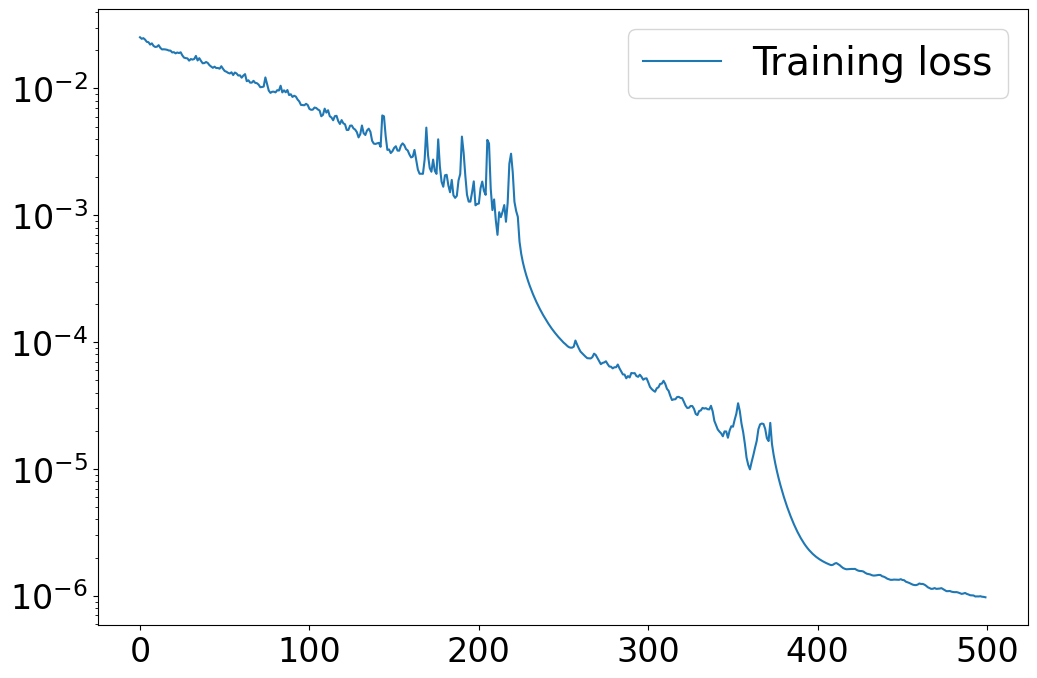

In [56]:
fig, ax = plt.subplots(figsize = (12,8))
ax.semilogy(train_loss_epochs, label = 'Training loss')
ax.legend(fontsize = 28)
ax.tick_params(axis='both', which='major', labelsize=24)
# plt.savefig(f'/work3/anscha/Marine_heat_waves/phytoplankton_NN/data/Phyto_Data/LSTM(Results)/Loss', dpi = 300, bbox_inches='tight')
plt.show()

In [57]:
##### Testing ################ 
print("Begin testing...")
BATCH_SIZE = 1
test_predicted_output, test_loss = test(model, criterion, X_test_scaled, BATCH_SIZE)
print("End testing...")

Begin testing...
End testing...


In [88]:
train_predicted_output.shape

(205, 923174)

In [91]:
############# for Training #############
n_variables = 7
### remove the mask channel and replace with nans
X_train_orig = np.ma.masked_where(nan_mask_train, X_train_scaled).filled(np.nan)
train_predicted_output_orig = np.ma.masked_where(nan_mask_train, train_predicted_output).filled(np.nan)

## inverse transform
X_train_orig = scaler.inverse_transform(X_train_orig)
train_predicted_output_orig = scaler.inverse_transform(train_predicted_output_orig)

#### reshape for restoring land
X_train_orig = X_train_orig.reshape(X_train_orig.shape[0], n_variables, int(X_train_orig.shape[1]/n_variables))
train_predicted_output_orig = train_predicted_output_orig.reshape(train_predicted_output_orig.shape[0], n_variables, int(train_predicted_output_orig.shape[1]/n_variables))

### restore land
X_train_orig = restore_land(X_train_orig, non_nan_indices_train)
train_predicted_output_orig = restore_land(train_predicted_output_orig, non_nan_indices_train)

X_train_orig = X_train_orig.swapaxes(0,1)
train_predicted_output_orig = train_predicted_output_orig.swapaxes(0,1)

print(X_train_orig.shape, train_predicted_output_orig.shape)

ValueError: could not broadcast input array from shape (205,7) into shape (205,1)

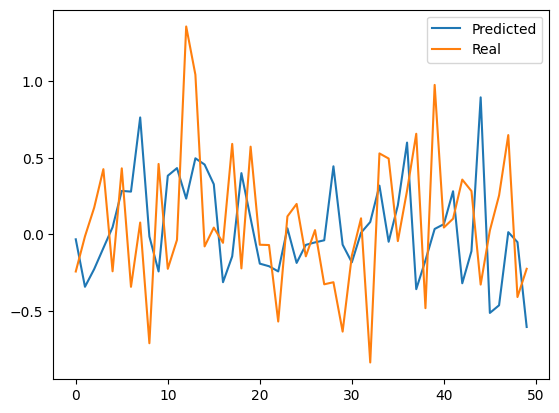

In [70]:
plt.plot(train_predicted_output_orig[0,:50,200,250], label = 'Predicted')
plt.plot(X_train_orig[0,:50,200,250], label = 'Real')
plt.legend()

In [76]:
# var_range_dict = {
#     '0': [-100, 100],
#     '1': [-1, 1],
#     '2': [-0.5, 0.5],
#     '3': [-1, 1],
#     '4': [-2, 2],
#     '5': [-0.5, 0.5],
#     '6': [-5, 5]
# }

### just for one variable
var_range_dict = {
    '0': [-2, 2]
}

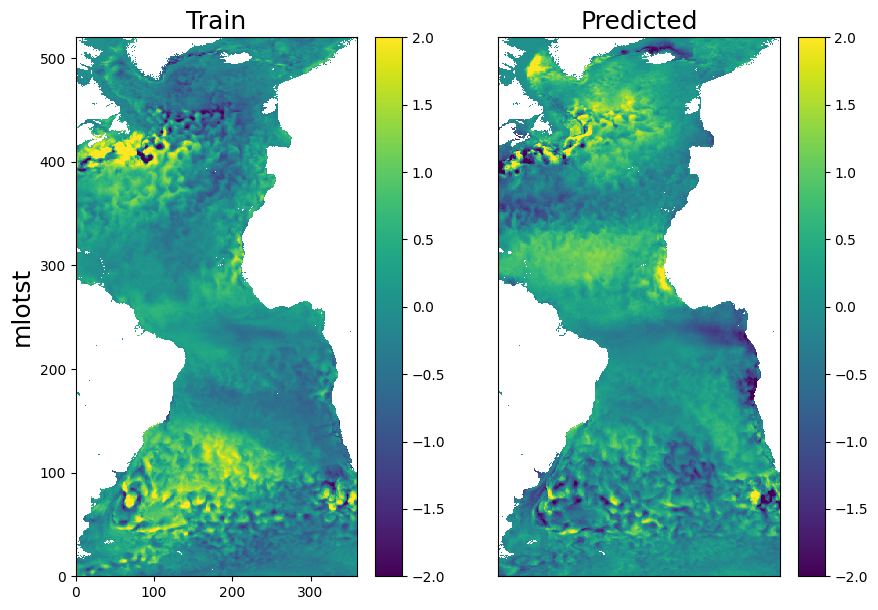

In [77]:
############################################################
#### comparison with predicted #########################
############################################################
import matplotlib.gridspec as gridspec

timestep = 0
n_var = 1

Tests = X_train_orig[:,timestep]
Preds = train_predicted_output_orig[:,timestep]

# create figure and gridspec
# fig = plt.figure(figsize=(10, 30))
fig = plt.figure(figsize=(10, 7)) ## just to have one variable
# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2, hspace=0.3)
gs = gridspec.GridSpec(n_var, 2, width_ratios=[1, 1])
# plot the heatmaps with the colorbars
for i in range(n_var):
        
    # create the subplot
    ax1 = plt.subplot(gs[i, 0])
    ax1.set_ylabel(f'{variables[i]}', fontsize = 18)
    im1 = ax1.pcolormesh(Tests[i], cmap='viridis', vmin = var_range_dict[f'{i}'][0], vmax = var_range_dict[f'{i}'][1])
    ax1.set_title(f'Train', fontsize = 18)  

    # ax1.set_xticks([])
    # ax1.set_yticks([])
    cbar1 = plt.colorbar(im1, ax=ax1)
    # cbar1.ax.set_ylabel('mg/m$^{-3}$', fontsize = 14, rotation = 270, labelpad = 24)

    # create the subplot
    ax2 = plt.subplot(gs[i, 1])
    im2 = ax2.pcolormesh(Preds[i], cmap='viridis', vmin = var_range_dict[f'{i}'][0], vmax = var_range_dict[f'{i}'][1])
    ax2.set_title(f'Predicted', fontsize = 18)
    ax2.set_xticks([])
    ax2.set_yticks([])
    cbar2 = plt.colorbar(im2, ax=ax2)
    # cbar2.ax.set_ylabel('mg/m$^{-3}$', fontsize = 14, rotation = 270, labelpad = 24)

## save figure for Test
# plt.savefig(f'/work3/anscha/Marine_heat_waves/phytoplankton_NN/data/Phyto_Data/CNN(Results)/CNN(baseline)/{selected_lead_month}_lead_month/Test', dpi = 300, bbox_inches='tight')
plt.show()

In [43]:
atlantic_data = ImportData.import_npy_data('.../atlantic_data.npy')
variables = np.array(['mlotst', 'oc', 'adt', 'sos', 'sst', 'WS', 'WSC'])

In [ ]:
###### min max scaling
def minmax_scale(data):
    min_vals = np.nanmin(data, axis=0, keepdims=True)
    max_vals = np.nanmax(data, axis=0, keepdims=True)
    data_range = max_vals - min_vals
    
    ### scale between -1 to 1
    data_scaled = 2 * (data - min_vals) / data_range - 1
    return data_range, min_vals, data_scaled

def minmax_descale(scaled_data, min_vals, train_range):
    original_data = (scaled_data * train_range) + min_vals
    return original_data

##### standardization
def standardize(data):
    mean_vals = np.nanmean(data, axis=0, keepdims=True)
    std_vals = np.nanstd(data, axis=0, keepdims=True)
    
    data_standardized = (data - mean_vals) / std_vals
    return mean_vals, std_vals, data_standardized

def destandardize(standardized_data, mean_vals, std_vals):
    original_data = (standardized_data * std_vals) + mean_vals
    return original_data

def remove_land(input_data): 
    # Reshape data by flattening the spatial dimensions
    data_reshaped = input_data.reshape(input_data.shape[0], 
                                       input_data.shape[1], 
                                       input_data.shape[2] * input_data.shape[3])

    nan_mask = np.isnan(data_reshaped).all(axis=(0, 1))
    non_nan_indices = np.where(~nan_mask)[0]
    data_cleaned = data_reshaped[:, :, ~nan_mask]

    return data_cleaned, non_nan_indices

def restore_land(data_cleaned, non_nan_indices):
    # # Create an empty array with the original spatial dimensions filled with NaN
    restored_data = np.full((data_cleaned.shape[0], data_cleaned.shape[1], 520, 360), np.nan)

    # Map the cleaned data back to its original spatial locations
    for i, idx in enumerate(non_nan_indices):
        lat_idx, lon_idx = np.unravel_index(idx, (520, 360))
        restored_data[:, :, lat_idx, lon_idx] = data_cleaned[:, :, i]

    return restored_data

In [ ]:
input_data = atlantic_data.swapaxes(0,1)

### remove land from data
input_data, non_nan_indices = remove_land(input_data)
input_data = input_data.reshape(input_data.shape[0], -1)

standardization = True

if standardization == True:
    mean_vals, std_vals, input_data_scaled = standardize(input_data)

else: 
    data_range, min_vals, input_data_scaled = minmax_scale(input_data)

input_data_scaled = np.nan_to_num(input_data_scaled, nan=0)

# Print the shapes
print(f"Scaled Train set shape: {input_data_scaled.shape}")

#################################################
## Apply PCA
#################################################
n_components = 20
pca = PCA(n_components=n_components)

PCA_result = pca.fit_transform(input_data_scaled)
print(f'Explained ratio by each PC: {pca.explained_variance_ratio_}')

## EOF Analysis

In [67]:
pca_weights = pca.components_

### descale data
if standardization == True:
    pca_weights_descaled = destandardize(pca_weights, mean_vals, std_vals)

else: 
    pca_weights_descaled = minmax_descale(pca_weights, min_vals, data_range)

pca_weights_descaled = pca_weights_descaled.reshape(pca_weights_descaled.shape[0], 7, int(pca_weights_descaled.shape[1]/7))
pca_weights_descaled = restore_land(pca_weights_descaled, non_nan_indices)

(20, 7, 520, 360)

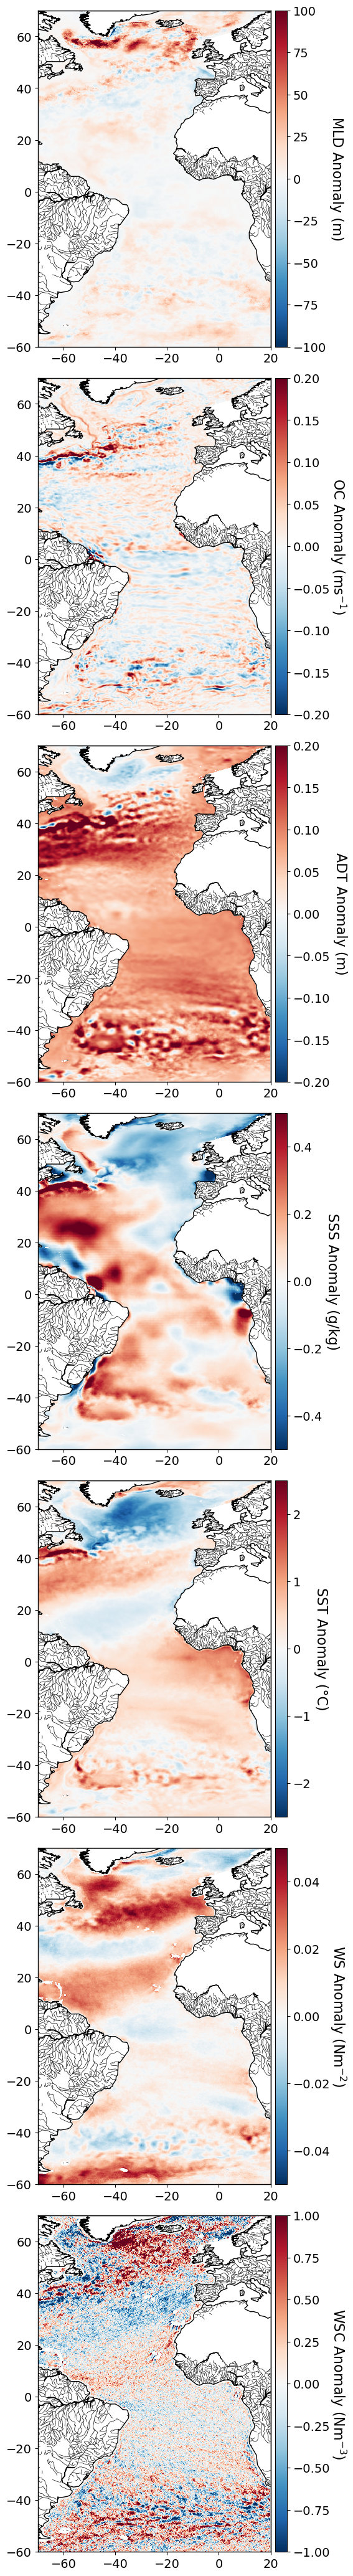

In [68]:
# Number of variables to plot
num_vars = 7
lat = np.arange(-70, 20, 0.25)
lon = np.arange(-60, 70, 0.25)
pc = 0
variables_for_plot = np.array(['MLD', 'OC', 'ADT', 'SSS', 'SST', 'WS', 'WSC'])
units = np.array(['m', r'ms$^{-1}$', 'm', 'g/kg', '°C', r'Nm$^{-2}$', r'Nm$^{-3}$'])
var_range_dict = {
    '0': [-100, 100],
    '1': [-0.2, 0.2],
    '2': [-0.2, 0.2],
    '3': [-0.5, 0.5],
    '4': [-2.5, 2.5],
    '5': [-0.05, 0.05],
    '6': [-1, 1]
}

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, 6 * num_vars))

for idx in range(num_vars):
    # Select the current axis
    ax = axes[idx]
    plt.sca(ax)

    # Create Basemap instance for each subplot
    m = Basemap(llcrnrlon=-70, llcrnrlat=-60, urcrnrlon=20, urcrnrlat=70, suppress_ticks=False, ax=ax)
    m.drawcoastlines()
    m.drawrivers()
    m.drawmapboundary()

    # Plot the data
    l = m.pcolormesh(lat, lon, pca_weights_descaled[pc, idx, :, :]*1000, cmap='RdBu_r', vmin=var_range_dict[f'{idx}'][0], vmax=var_range_dict[f'{idx}'][1])

    # Set title for each subplot
    # plt.title(f'{variables_for_plot[idx]}', fontsize=28)
    ax.tick_params(labelsize=14)
    
    cbar = m.colorbar(l)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(f'{variables_for_plot[idx]} Anomaly ({units[idx]})', rotation=270, fontsize=16, labelpad=20) #°C

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

## Clustering Analysis

In [ ]:
pc = 0

pca_weights = pca.components_
pca_weights = pca_weights.reshape(pca_weights.shape[0], 7, int(pca_weights.shape[1]/7))

vecs = pca_weights[pc].T
MM = KMeans()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f930d688b80>
Traceback (most recent call last):
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

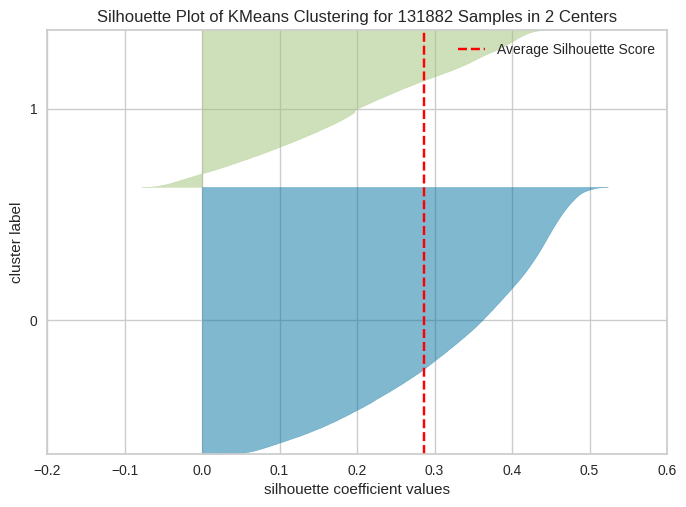

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f930d489790>
Traceback (most recent call last):
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

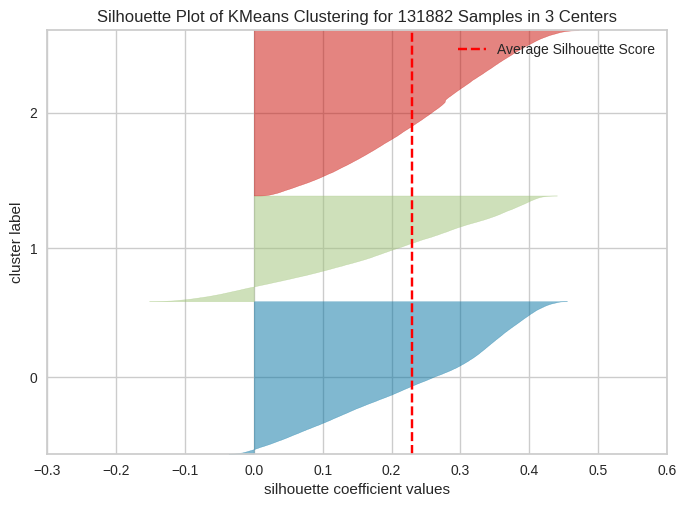

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f930d3b8ee0>
Traceback (most recent call last):
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

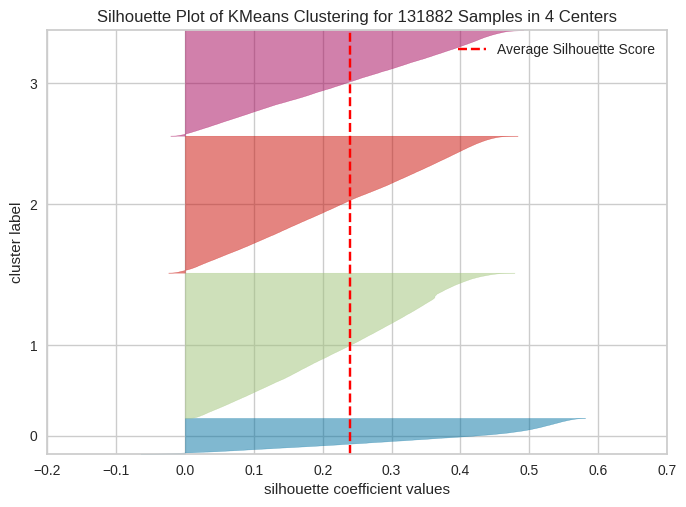

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f930d3b8ee0>
Traceback (most recent call last):
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/zhome/01/2/144033/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

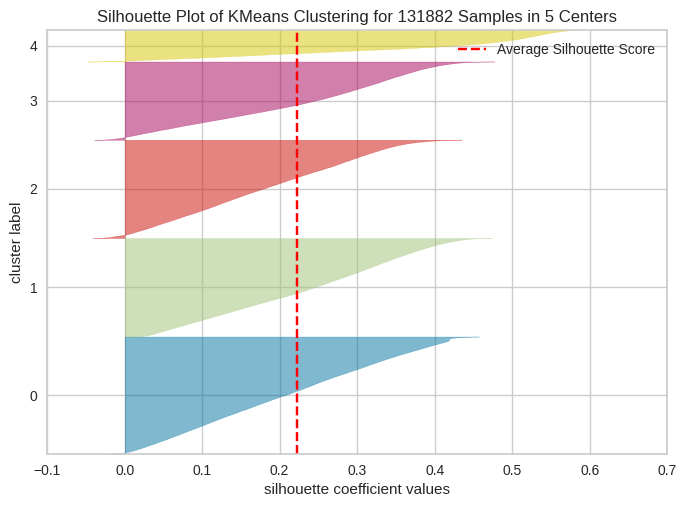

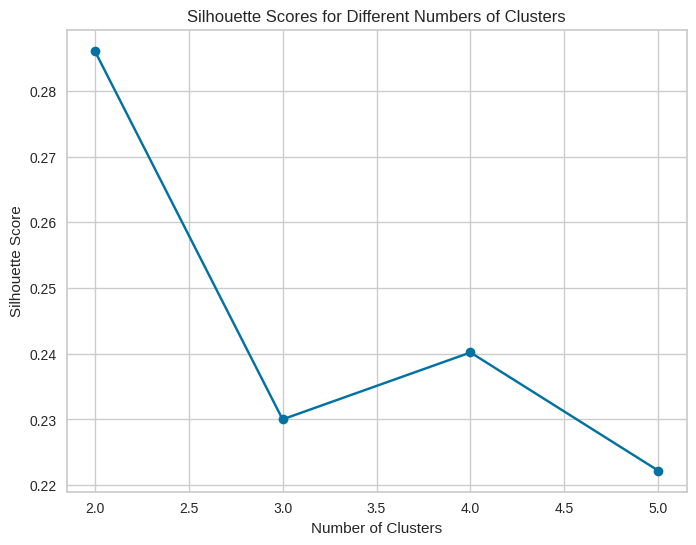

The optimal number of clusters is: 2


In [24]:
# List to store the silhouette scores for different values of k
silhouette_scores = []

# Range of clusters to try
range_n_clusters = list(range(2, 6))

for n_clusters in range_n_clusters:
    # Initialize the KMeans model
    model = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Create a silhouette visualizer with the model
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    
    # Fit the data to the visualizer
    visualizer.fit(vecs)
    
    # Save the silhouette score for this number of clusters
    silhouette_scores.append(visualizer.silhouette_score_)
    
    # Show the visualization
    visualizer.show()

# Plot silhouette scores for each number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Optimal number of clusters is the one with the highest silhouette score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")

In [71]:
n_clus = np.arange(3,9)
n_clus_labels = np.zeros((n_clus.shape[0], vecs.shape[0]))

for i, n in enumerate(n_clus):
    MM_ = KMeans(n_clusters=n)
    MM_.fit(vecs)
    n_clus_labels[i] = MM_.labels_

n_clus_labels = n_clus_labels.reshape(1, n_clus_labels.shape[0], n_clus_labels.shape[1])
clus_based_map = restore_land(n_clus_labels, non_nan_indices)
clus_based_map.shape

(1, 6, 520, 360)

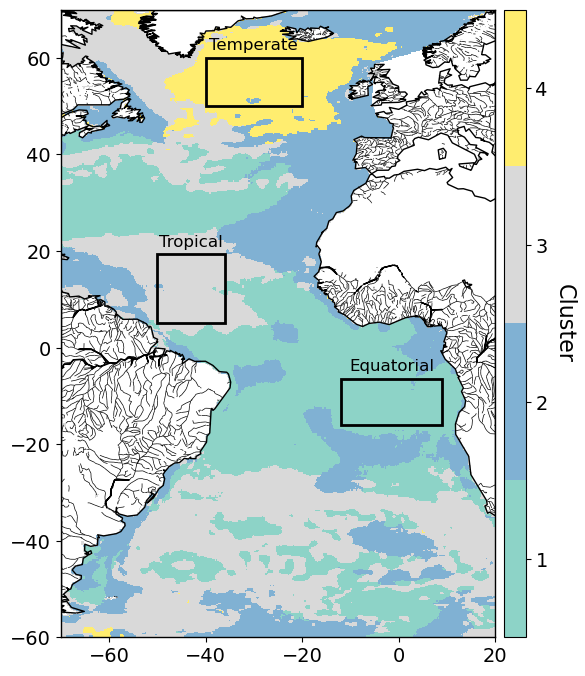

In [77]:
from matplotlib.patches import Polygon
# Define your polygons coordinates and labels
polygons = [
    ([[-40, 60], [-40, 50], [-20, 50], [-20, 60]], "Temperate"),  # First polygon
    ([[-50, 5], [-36, 5], [-36, 19.285], [-50, 19.285]], "Tropical"),  # Second polygon
    ([[9, -6.477], [-12, -6.477], [-12, -16], [9, -16]], "Equatorial")  # Third polygon
]

count = 1

fig, ax = plt.subplots(figsize=(6, 9))

# Create Basemap instance for the subplot
m = Basemap(llcrnrlon=-70, llcrnrlat=-60, urcrnrlon=20, urcrnrlat=70, suppress_ticks=False, ax=ax)
m.drawcoastlines()
m.drawrivers()
m.drawmapboundary()

lat = np.arange(-70, 20, 0.25)
lon = np.arange(-60, 70, 0.25)
cmap = plt.get_cmap('Set3', n_clus[count])
c = m.pcolormesh(lat, lon, clus_based_map[0, count], cmap=cmap)

# Add polygons to map
for poly_coords, label in polygons:
    # Convert the polygon points to map coordinates
    poly = Polygon([m(x, y) for x, y in poly_coords], closed=True, edgecolor='k', facecolor='none', linewidth=2)  # thicker edge
    ax.add_patch(poly)
    
    # Place a text label above the polygon
    label_x = np.mean([p[0] for p in poly_coords])
    label_y = max([p[1] for p in poly_coords]) + 1  # Increase y by 1 degree for higher positioning
    label_x, label_y = m(label_x, label_y)  # Convert to map coordinates
    plt.text(label_x, label_y, label, fontsize=12, ha='center', va='bottom', color='black')

# Add colorbar
cbar = m.colorbar(c, ax=ax)
tick_locs = (np.arange(n_clus[count]) + 0.5)*(n_clus[count]-1)/n_clus[count]
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_clus[count]+1))
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Cluster', rotation=270, fontsize=16, labelpad=20)

ax.tick_params(labelsize=14)
# plt.savefig(f'/work3/anscha/Marine_heat_waves/Manuscript2_figures/Clusters (KMeans).jpg', dpi = 300, bbox_inches = 'tight')

plt.show()

In [73]:
pca_weights_1 = pca_weights.reshape(
    pca_weights.shape[0], pca_weights.shape[1]*pca_weights.shape[2])

if standardization == True:
    pca_weights_1 = destandardize(pca_weights_1, mean_vals, std_vals)

else: 
    pca_weights_1 = minmax_descale(pca_weights_1, min_vals, data_range)

pca_weights_1 = pca_weights_1.reshape(
    pca_weights_1.shape[0], 7, int(pca_weights_1.shape[1]/7))

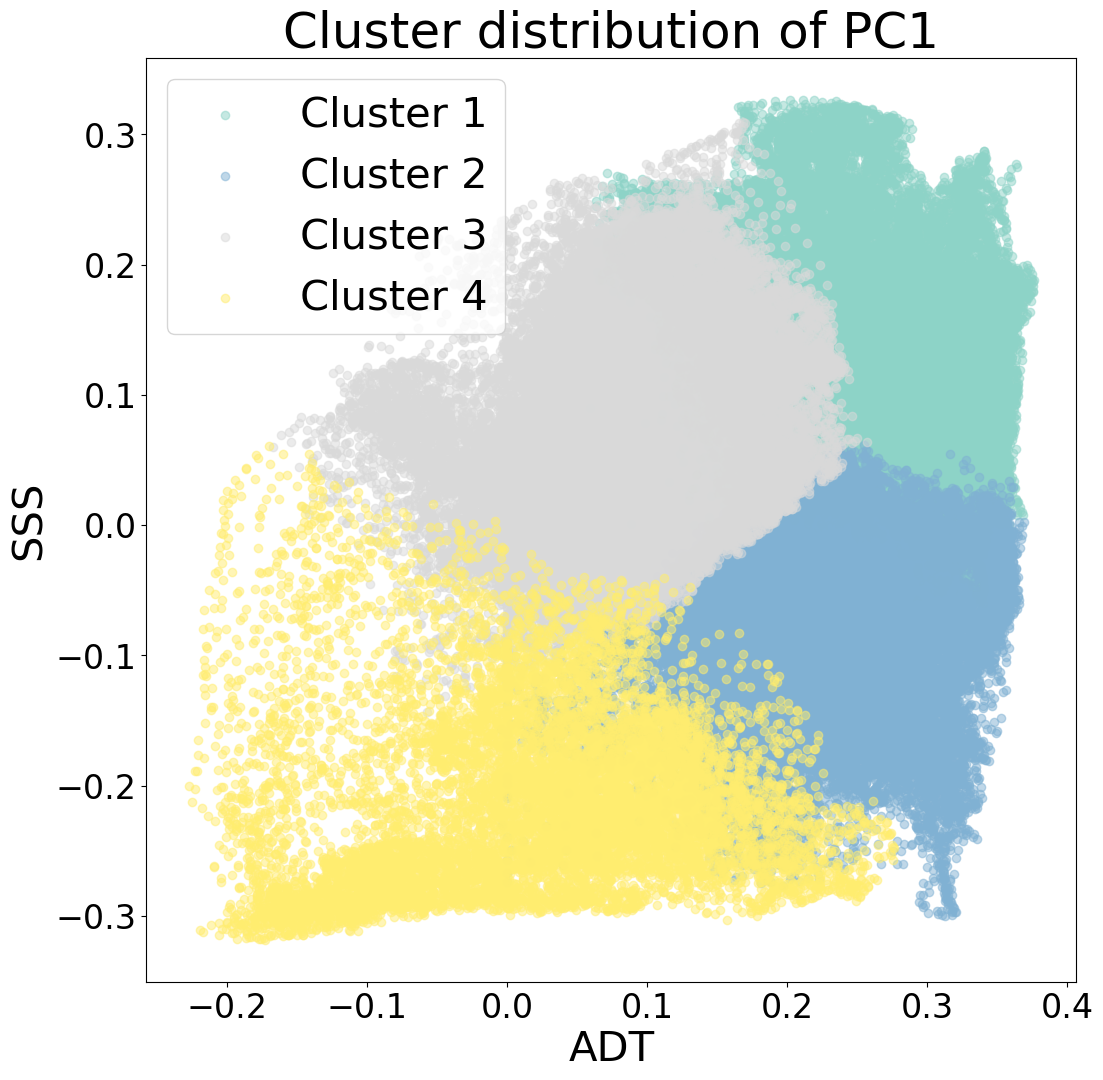

In [78]:
var1 = 2
var2 = 3
X = pca_weights[0, var1]*100
Y = pca_weights[0, var2]*100
labels = n_clus_labels[0, count]
# Define a color map
cmap = plt.get_cmap('Set3', n_clus[count])
# Create the scatter plot
fig, ax = plt.subplots(figsize = (12,12))

for label in np.unique(labels).astype(int):
    ax.scatter(X[labels == label], Y[labels == label], c=[cmap(label)], alpha = 0.5, label=f'Cluster {label+1}')

ax.set_xlabel(f'{variables_for_plot[var1]}', fontsize = 30)
ax.set_ylabel(f'{variables_for_plot[var2]}', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_title('Cluster distribution of PC1',  fontsize = 36)
plt.legend(fontsize = 30)
# plt.savefig(f'/work3/anscha/Marine_heat_waves/Manuscript2_figures/Clusters distribution (KMeans).jpg', dpi = 300, bbox_inches = 'tight')
plt.show()